<a href="https://colab.research.google.com/github/sefeoglu/deeplearning-projects-and-kaggle-competitions/blob/master/SimpleMaskClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color = "green">Simple Classification of People with a Mask</font>**


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
from zipfile import ZipFile 

In [ ]:
import pandas as pd
from os import listdir
from os.path import isfile, join

**<font color="blue"> Extract the data</font>**



In [ ]:
file_name = "data.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

**Prepare the images for fast.ai pretrained models**





In [ ]:
folder = "data"
files = os.listdir(folder)
labels = files
image_folder = "images/"
os.makedirs(image_folder)

In [ ]:
delimineter = "/"
# change the names as label_number.png for fast.ai
for label in labels:
  file_path = folder+delimineter+label+delimineter
  dirs = os.listdir( file_path )
  for file in dirs:
    digit_name = int(''.join(filter(str.isdigit, str(file))))
    os.rename(file_path+file, file_path+str(label)+"_"+str(digit_name)+".png")
# copy the images to images/ directory
for label in labels:
  file_path = folder+delimineter+label+delimineter
  dirs = os.listdir( file_path )
  for file in dirs:
    shutil.copy(file_path+file, image_folder)
    

In [ ]:
fnames = get_image_files(image_folder)
# Print the number of images we have
print("Number of images:{0}".format(len(fnames)))
fnames[:5]

Number of images:1849


[PosixPath('images/mask_1295.png'),
 PosixPath('images/no_mask_1839.png'),
 PosixPath('images/no_mask_398.png'),
 PosixPath('images/mask_3134.png'),
 PosixPath('images/mask_4.png')]

In [ ]:
bs = 64

In [ ]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.png$'

In [ ]:
path_img = "images/"

In [ ]:
fnames = get_image_files("images/")
fnames[:10]

[PosixPath('images/incorrect_mask_2258.png'),
 PosixPath('images/mask_3640.png'),
 PosixPath('images/mask_2420.png'),
 PosixPath('images/mask_849.png'),
 PosixPath('images/mask_1949.png'),
 PosixPath('images/mask_2432.png'),
 PosixPath('images/mask_1819.png'),
 PosixPath('images/mask_233.png'),
 PosixPath('images/mask_2091.png'),
 PosixPath('images/mask_3259.png')]

In [ ]:
data = ImageDataBunch.from_name_re(path_img,fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

**check the images**

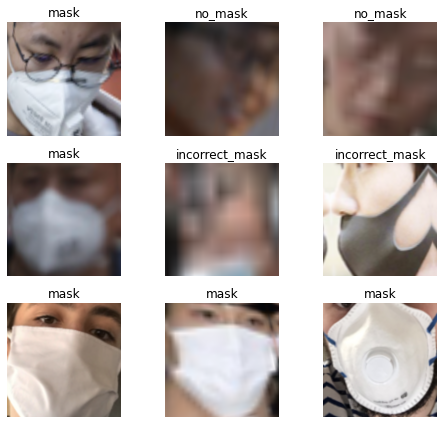

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

['incorrect_mask', 'mask', 'no_mask']


(3, 3)

# **ResNet34**

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.model

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.426170,0.535765,0.165312,00:12
1,0.981984,0.380484,0.116531,00:12
2,0.708513,0.246021,0.084011,00:12
3,0.520968,0.257688,0.075881,00:12
4,0.407594,0.209366,0.067751,00:12
5,0.351927,0.234330,0.065041,00:12
6,0.297108,0.195003,0.073171,00:12
7,0.269504,0.179557,0.051491,00:12
8,0.232253,0.190770,0.056911,00:12
9,0.212634,0.178582,0.048780,00:12


**<font color = "purple">Discussion:</font>**
The training and validation losses are quite low, and error rate,too. However, we searched if we can find the better model after fine tuning.

In [ ]:
learn.save('stage-1')

In [ ]:
def check(learn):
  """check the confusion matrix"""
  interp = ClassificationInterpretation.from_learner(learn)
  losses,idxs = interp.top_losses()
  len(data.valid_ds)==len(losses)==len(idxs)
  interp.plot_top_losses(9, figsize=(15,11))
  interp.plot_confusion_matrix(figsize=(4,4), dpi=60)
  
  for line in interp.most_confused(min_val=2):
    print(line)

('no_mask', 'mask', 7)
('incorrect_mask', 'mask', 5)
('incorrect_mask', 'no_mask', 3)
('mask', 'no_mask', 2)


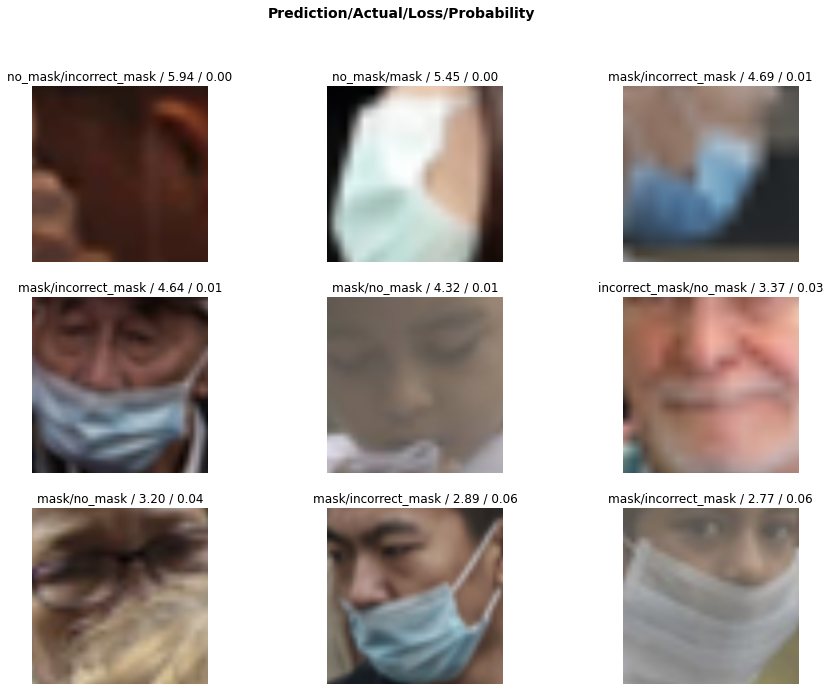

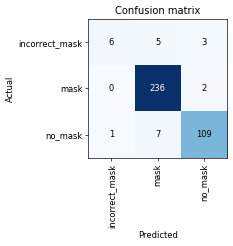

In [ ]:
check(learn)

**<font color = "purple">Discussion: </font>**

People without mask ware predicted incorrect for 12 cases as if they have a mask. 

As a result of the first 8 epoch trainig, the model has some series misclassification errors. Let's apply fine-tuning.

# **Fine Tuning, Unfreeze**

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.247478,0.208228,0.059621,00:13


This train loss above is quite high, so we are applying the fine tuning

In [ ]:
learn.load('stage-1');
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


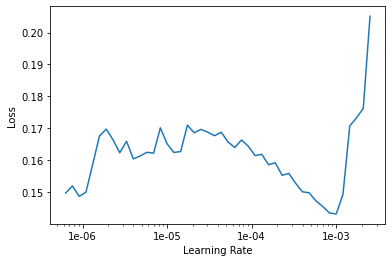

In [ ]:
learn.recorder.plot()

The loss between 1e-04 and 1e-03 is decreasing before and after the aforementioned value it's not decreasing so we'll choose the learning rate as per se.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.217637,0.514076,0.146341,00:32
1,0.313145,0.169232,0.056911,00:31
2,0.212304,0.108419,0.032520,00:31
3,0.139701,0.109161,0.029810,00:32


('no_mask', 'mask', 4)
('incorrect_mask', 'mask', 3)
('incorrect_mask', 'no_mask', 3)
('no_mask', 'incorrect_mask', 2)


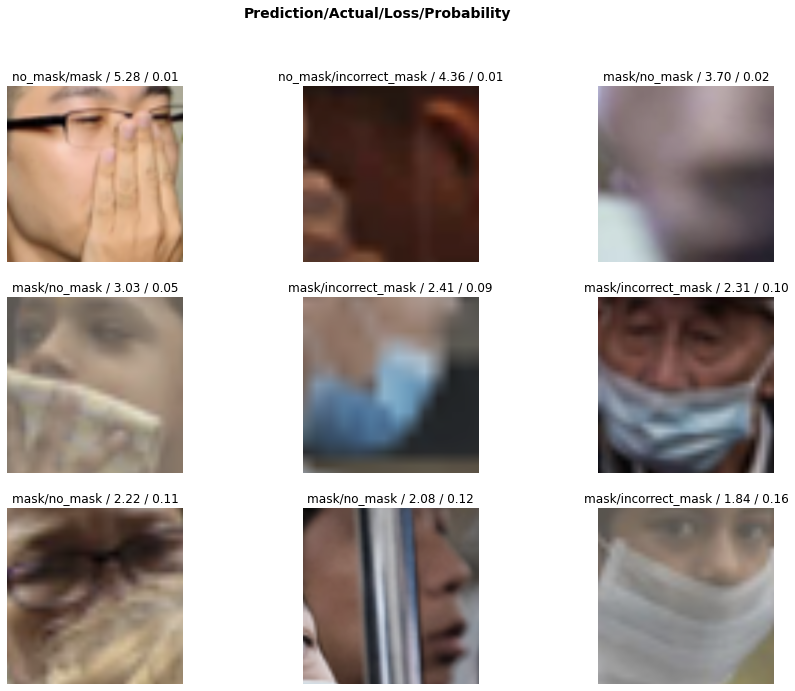

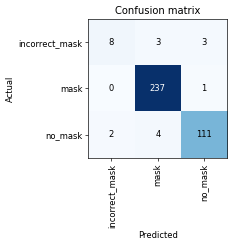

In [ ]:
check(learn)

**That's a pretty accurate model :)** 

**<font color = "purple">Discussion: </font>**
The model can predict people with people properly. However, the model misclassified 7 people without a mask as with a mask. This misclassification error can be excepted. We have a small dataset. On the other hand, 1 mask images classified as no_mask, this can be acceptable because this might not cause a big problem in real life. Lastly, 3 incorrect_masks were misclassified as no_mask, and this mistake is not serious.

In addition to this, some images were labeled with the wrong tag, and this is another problem. Check image 1.

# **RESNET50**

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=300, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


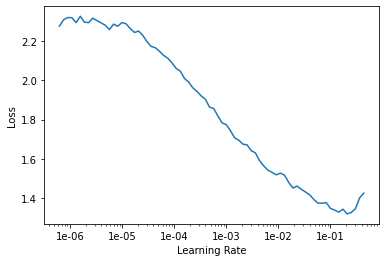

In [ ]:
learn.lr_find()
learn.recorder.plot()

* Apply fine tuning for learning rate interval between 1e-04 and 1e-03 after fitting the model for 16 epochs. The reason of this choice for learning rate was mentioned in ResNet34 part below

In [ ]:
learn.fit_one_cycle(16)

epoch,train_loss,valid_loss,error_rate,time
0,1.041492,0.636178,0.192412,00:25
1,0.732465,0.366578,0.094851,00:24
2,0.595879,0.428392,0.111111,00:24
3,0.481938,0.246313,0.070461,00:24
4,0.369582,0.249865,0.070461,00:24
5,0.304414,0.198159,0.067751,00:24
6,0.266402,0.199117,0.065041,00:23
7,0.224278,0.229661,0.081301,00:24
8,0.200138,0.196109,0.062331,00:24
9,0.175715,0.163878,0.043360,00:24


The results show that the validation loss is quite low and error rate is also good.Therefore, save the model to use later.

In [ ]:
learn.save('stage-1-50')

**Apply fine tuning to find the better model**

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-05, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.130513,0.242643,0.056911,00:33
1,0.162463,0.176198,0.051491,00:31
2,0.110465,0.149337,0.035230,00:31


**<font color = "purple">Discussion: </font>**

In [ ]:
#learn.save('stage-1-50')# decide it depending on the fine tuning results
#learn.load('stage-1-50')# decide it depending on fine tuning

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('incorrect_mask', 'no_mask', 3),
 ('mask', 'no_mask', 3),
 ('incorrect_mask', 'mask', 2),
 ('mask', 'incorrect_mask', 2),
 ('no_mask', 'mask', 2)]

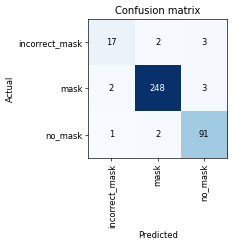

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

**<font color = "purple">Discussion: </font>**
After the fine-tuning, the model misclassified 4 cases as masks. This result is good when the result is compared with the result of the model before fine-tuning. Fortunely, we obtained the same error rate after fine tuning, when we check the validation and training losses of both models, the previous model is better than the last one.

**Load previous model**

In [ ]:
learn.load('stage-1-50')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('incorrect_mask', 'mask', 7),
 ('incorrect_mask', 'no_mask', 2),
 ('no_mask', 'incorrect_mask', 2)]

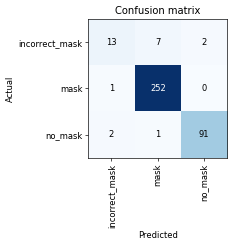

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

**<font color = "purple">Discussion: </font>** previous model without fine tuning misclassified 8 cases as masks. 

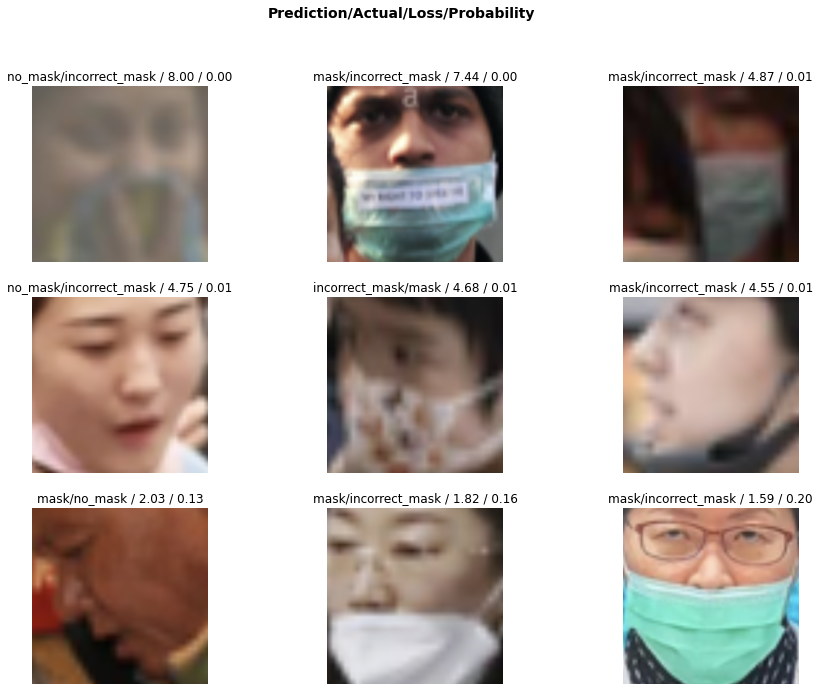

In [ ]:
  losses,idxs = interp.top_losses()
  len(data.valid_ds)==len(losses)==len(idxs)
  interp.plot_top_losses(9, figsize=(15,11))